**Standalone analysis**

Made for analysis of one flow dynamics

**🚫 Deprecated notebook - Please use the [flow analysis](./flow_analysis.ipynb) or the [unalimented analysis](./unalimented_temperature_analysis.ipynb), which is more complete and efficient**

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

# Open and parse data

## Open from files

In [4]:
path = 'results/26.11.not_filled/IMG_0808.avi'
date = '2024-12-17_17-07-30'

In [5]:
info_df = pd.read_csv(f'{path}.csv')
framerate = int(info_df.framerate.iloc[0]) # In FPS
width = int(info_df.width.iloc[0])
height = int(info_df.height.iloc[0])

min_time = 806/60

In [6]:
df = pd.read_csv(f'{path}.{date}.csv')
#thickness_df = pd.read_csv(f'{path}.{date}.thickness.csv')

df.drop(df[df.time < min_time].index, inplace = True)
#thickness_df.drop(thickness_df[thickness_df.time < min_time].index, inplace = True)

#df.set_index('frame', inplace=True)

# Code utilities

## Plotting style for projectors

## Area over time

In [8]:
study_df = df.copy()
study_df['log_time'] = np.log(study_df['time'])
study_df['area_smooth'] = savgol_filter(study_df.area, window_length=11, polyorder=5)

In [9]:
window_df = df[(df.time >= 22) & (df.time <= 50)].copy()

[]

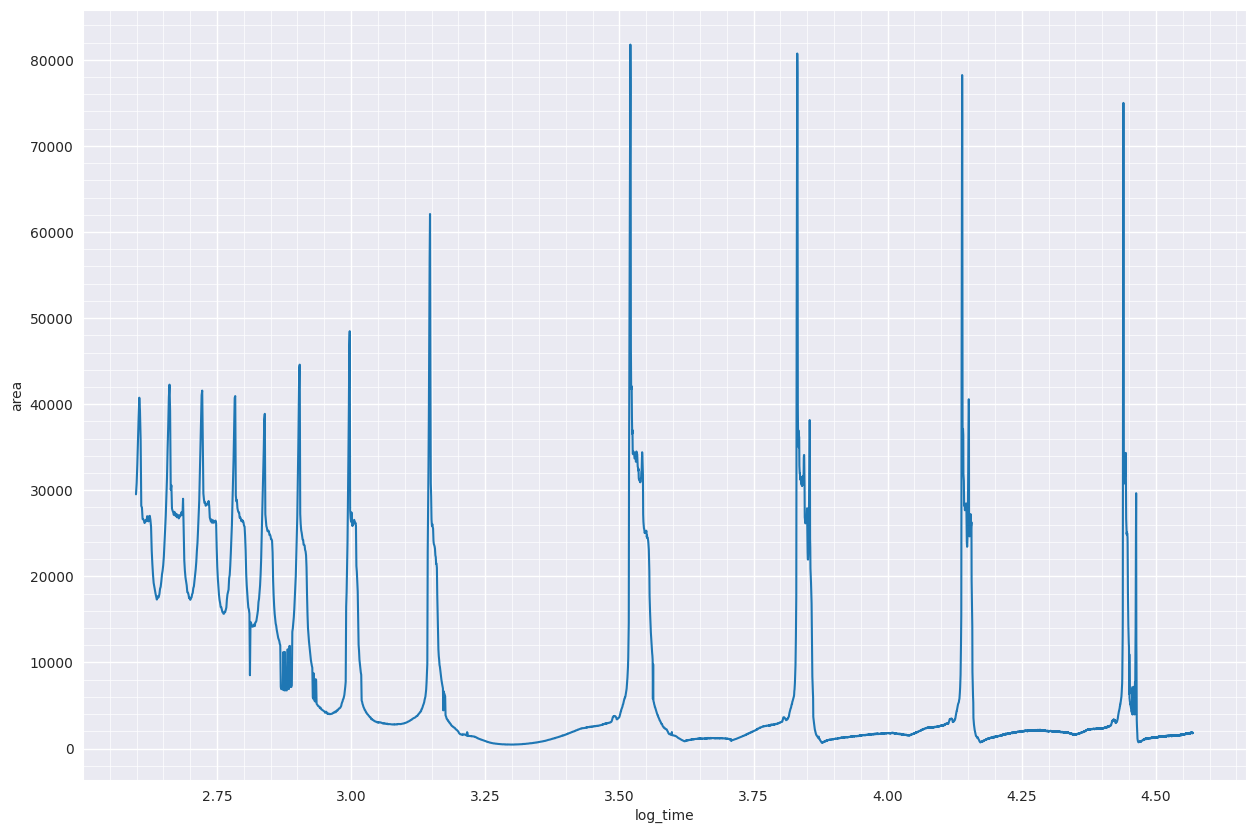

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(which='major', color='w', linewidth=1.0)
ax.grid(which='minor', color='w', linewidth=0.5)
sns.lineplot(study_df, x='log_time', y='area', ax=ax, errorbar=None)
plt.plot()

- Explorer le rebond qui se produit à chaque pic
- Expliquer l'amplitude de temps d'une goutte
- Voir l'avant-goutte, si on trouve une relation pour expliquer la croissance de l'aire

In [12]:
# Legacy code, no longer appropriate for a proper area analysis
#
# segments = [(1710, 1860), (1895, 2030), (2100, 2850), (1900, 2000)]
# 
# for start, end in segments:
#     segment_df = study_df.loc[start:end]
#     # Fit a polynomial to the segment
#     poly_coeffs = np.polyfit(segment_df.time, segment_df.area_smooth, deg=3)  # Try degrees 2 or 3
#     poly_curve = np.polyval(poly_coeffs, segment_df.time)
#     
#     # Replace the segment in the smoothed data
#     study_df.loc[start:end, 'area_smooth'] = poly_curve

TypeError: expected non-empty vector for x

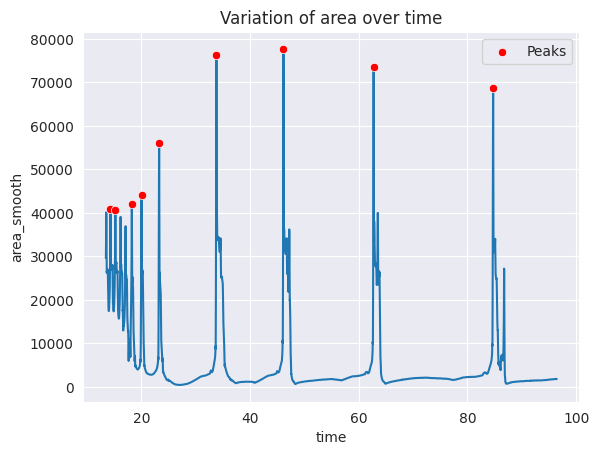

In [17]:
from scipy.signal import find_peaks

threshold = 39000
threshold_df = study_df[study_df.area > threshold]

peaks_i, _ = find_peaks(threshold_df.area_smooth, prominence=1)
peaks_df = threshold_df.iloc[peaks_i]
sns.lineplot(study_df, x='time', y='area_smooth', errorbar=None)
sns.scatterplot(peaks_df, x='time', y='area_smooth', color='red', label='Peaks', zorder=5)
plt.title('Variation of area over time')
plt.legend()
plt.show()

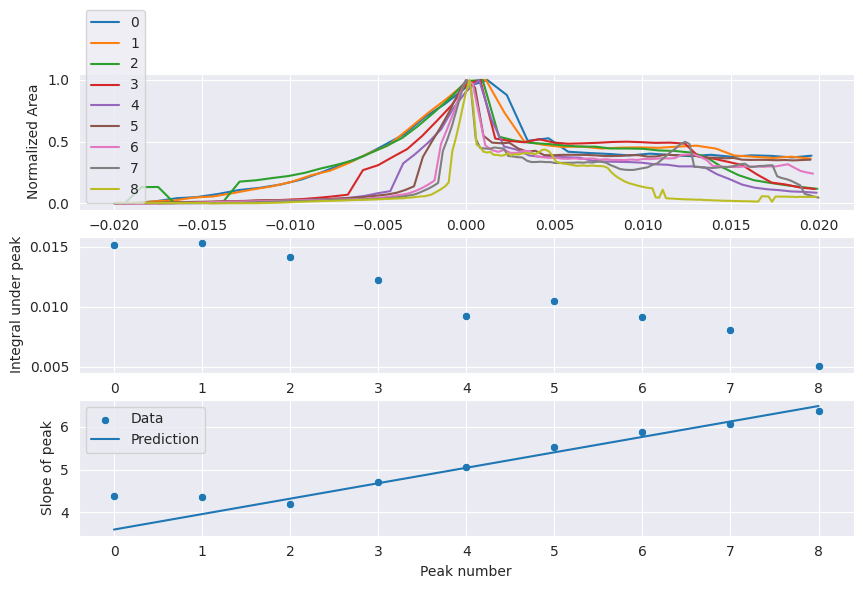

In [57]:
range_value = 0.02

normalization_y = 0.6
tolerance = 7e-2
integrals = []
slopes = []

# Example plot, assuming you want to plot `x_column` vs `y_column`
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))

for i, point in enumerate(peaks_df['log_time']):

  # Data fetching
  temp_df = study_df[(study_df['log_time'] >= point - range_value) & (study_df['log_time'] <= point + range_value)]
  x = temp_df['log_time'].values - point
  y = temp_df['area'].values
  y = (y - np.min(y)) / (np.max(y) - np.min(y))
  
  integral = np.trapz(y, x)
  integrals.append(integral)
  
  start_idx = np.where(y >= 0.2)[0][0]
  x_start, y_start = x[start_idx], y[start_idx]

  # Find the peak (maximum y value and its corresponding x value)
  peak_idx = np.argmax(y)  # Index of maximum y value
  x_peak, y_peak = x[peak_idx], y[peak_idx]
  slope = (y_peak - y_start) / (x_peak - x_start)
  slopes.append(slope)
  
  filtered_df = temp_df[np.isclose(y, normalization_y, atol=tolerance)]
  # x_left = filtered_df['log_time'].min()
  # x_right = filtered_df['log_time'].max()
  # width = x_right - x_left
  # x=(x - (x_left + x_right) / 2) / width

  # intercept = y_start - slope * x_start
  # x_line = np.linspace(x_start, x_peak, 100)
  # y_line = np.polyval((slope, intercept), x_line)
  
  sns.lineplot(x=x, y=y, label=f'{i}', ax=ax1)

n = np.arange(0,9)
sns.scatterplot(x=n, y=integrals, ax=ax2)

coefficients = np.polyfit(n[2:], np.log(slopes[2:]), 1)
slope, intercept = coefficients

slopes_pred = slope * n + intercept
sns.scatterplot(x=n, y=np.log(slopes), ax=ax3, label='Data')
sns.lineplot(x=n, y=slopes_pred, ax=ax3, label='Prediction')

ax1.set_xlabel('Log-Time')
ax1.set_ylabel('Normalized Area')
ax1.legend()

ax2.set_xlabel("Peak number")
ax2.set_ylabel("Integral under peak")
ax3.set_xlabel("Peak number")
ax3.set_ylabel("Slope of peak")
ax3.legend()

plt.show()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

- tracer les vidéos en même temps que les courbes

<Axes: xlabel='log_time', ylabel='area_smooth'>

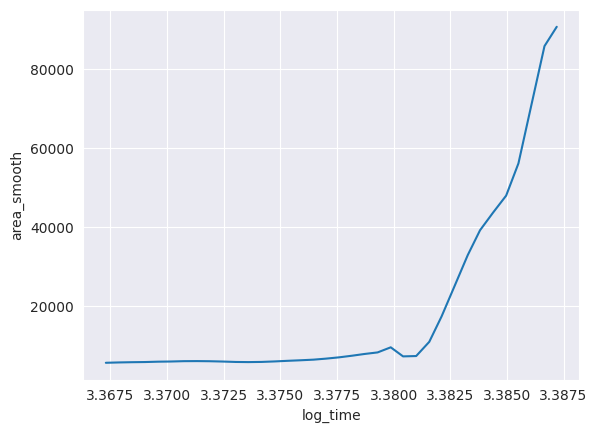

In [77]:
range_before = 0.02
temp_df = study_df[(study_df['log_time'] >= point - range_before) & (study_df['log_time'] <= point)]
sns.lineplot(temp_df, x='log_time', y='area_smooth', markers='o')

<Axes: ylabel='log_time'>

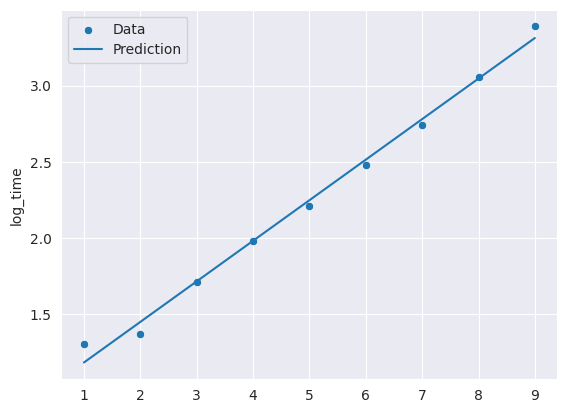

In [84]:
X = np.arange(len(peaks_df)) + 1

coefficients = np.polyfit(X, peaks_df['log_time'], 1)  # Degree 1 for linear regression
slope, intercept = coefficients

log_time_pred = slope * X + intercept

sns.scatterplot(peaks_df, x=X, y='log_time', label='Data')
sns.lineplot(x=X, y=log_time_pred, label='Prediction')

<Axes: >

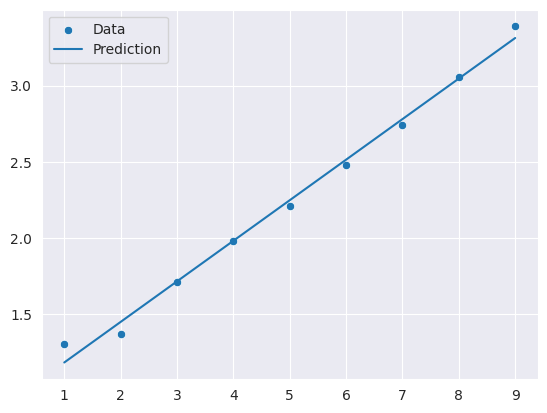

In [24]:
X = np.arange(len(peaks_time)) + 1
log_time = np.log(peaks_time).values

coefficients = np.polyfit(X, log_time, 1)  # Degree 1 for linear regression
slope, intercept = coefficients

log_time_pred = slope * X + intercept

sns.scatterplot(x=X, y=log_time, label='Data')
sns.lineplot(x=X, y=log_time_pred, label='Prediction')

In [50]:
print(f'Relation: t_n = exp({slope}n + {intercept})')

Relation: t_n = exp(0.2809761827354824n + 1.6585076936824832)


In [44]:
intercept

array([1.97865389, 2.21189423, 2.4765384 , 2.74406064, 3.05319897,
       3.38719987])

## Thickness for specific layers over time

In [128]:
def frame_to_time(frame_number):
    time_in_seconds = frame_number / framerate
    minutes = int(time_in_seconds // 60)
    seconds = int(time_in_seconds % 60)
    milliseconds = int((time_in_seconds - int(time_in_seconds)) * 1000)
    return f"{minutes}:{seconds:02d}:{milliseconds:03d}"

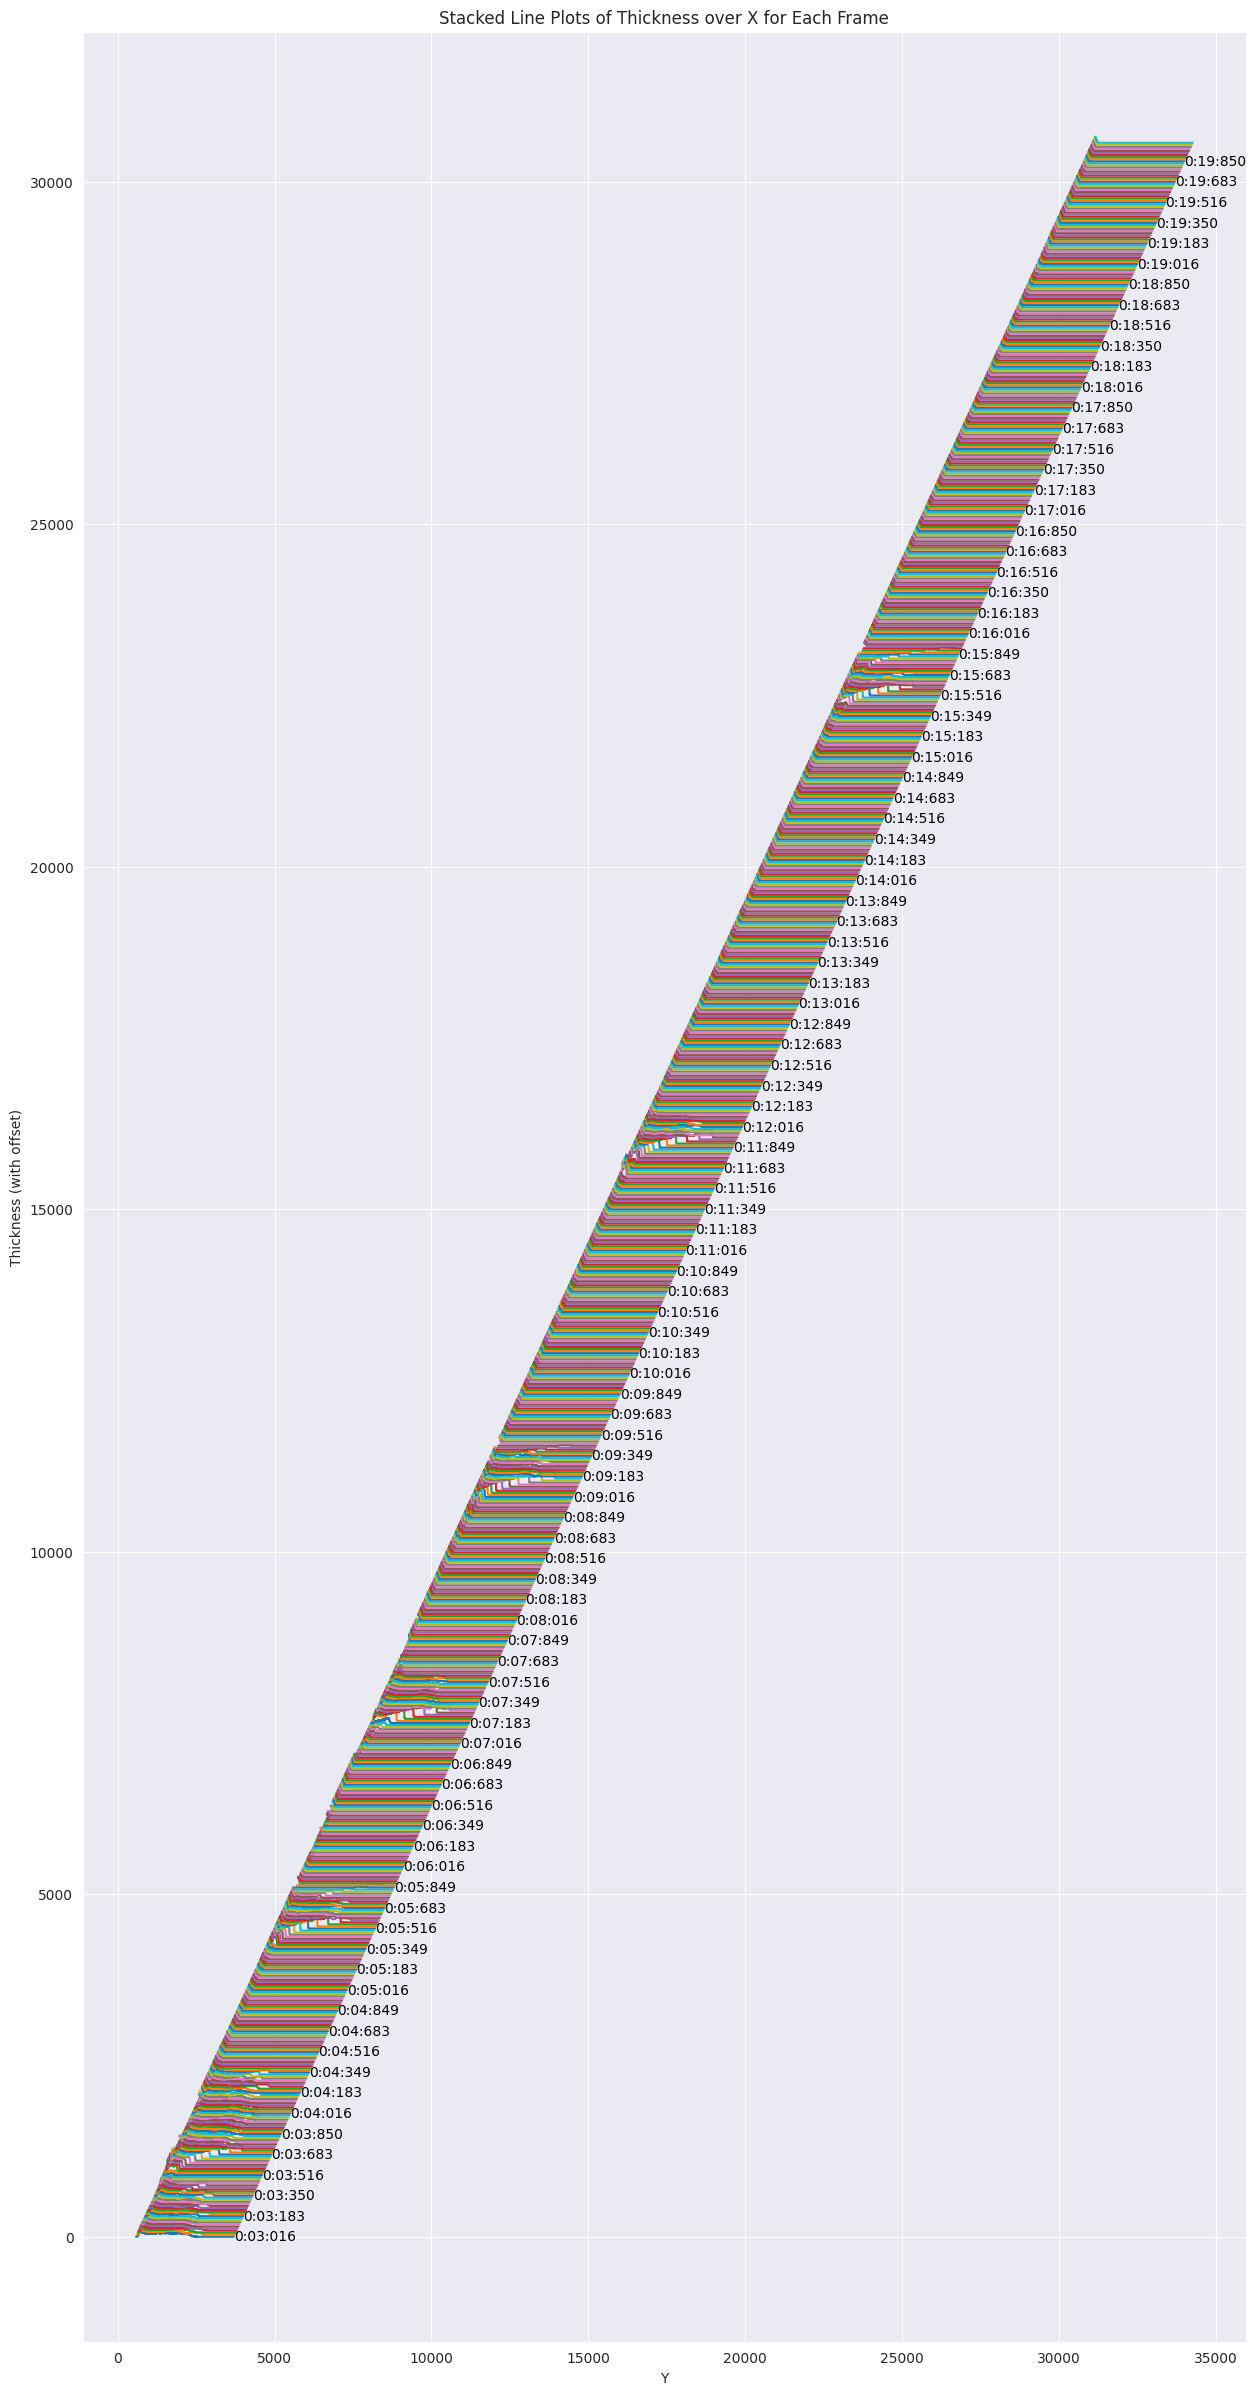

In [130]:
# Plot for t multiple of ...
frame_multiple = 1
time_min = 3
time_max = 20

frame_min = framerate * time_min
frame_max = framerate * time_max

thickness_filtered = thickness_df[
  (thickness_df['frame'] % frame_multiple == 0) & (thickness_df['frame'] >= frame_min) & (thickness_df['frame'] <= frame_max)
]
frames = thickness_filtered['frame'].unique()

offset_step = 30
plt.figure(figsize=(15, 30))

for i, frame in enumerate(frames):
  row = thickness_filtered[thickness_filtered['frame'] == frame]
  offset = i * offset_step
  
  plt.plot(row['y'] + offset, row['thickness'] + offset, label=f'Frame {frame}')
  if i % 10 == 0:
    plt.text(max(row['y']) + 0.5 + offset, row['thickness'].iloc[-1] + offset, f'{frame_to_time(frame)}',
       verticalalignment='center', fontsize=10, color='black')
  #plt.hlines(offset, xmin=min(thickness_filtered['x']) + offset, xmax=max(thickness_filtered['x']) + offset, color='black', alpha=0.5, linestyle='--')

plt.title('Stacked Line Plots of Thickness over X for Each Frame')
plt.xlabel('Y')
plt.ylabel('Thickness (with offset)')
plt.grid(True)

plt.show()

Text(0, 0.5, 'Max thickness')

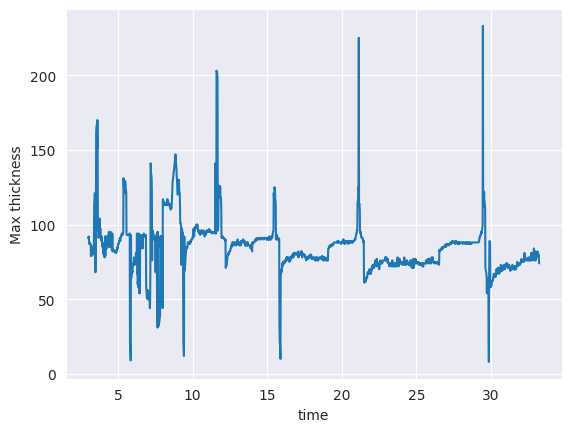

In [132]:
mean_thickness_df = thickness_df.groupby('time')['thickness'].max().reset_index()
sns.lineplot(mean_thickness_df, x='time', y='thickness')
plt.ylabel('Max thickness')

Observation: the trickle is growing until falling, and after its size reduces

Text(0, 0.5, 'Mean thickness')

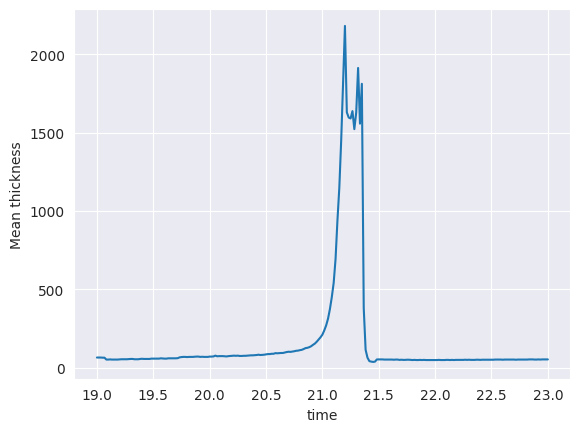

In [107]:
sns.lineplot(mean_thickness_df[(mean_thickness_df['time'] >= 19) & (mean_thickness_df['time'] <= 23)], x='time', y='thickness')
plt.ylabel('Mean thickness')

Text(0.5, 1.0, 'Thickness graph for the honey trickle at t=15')

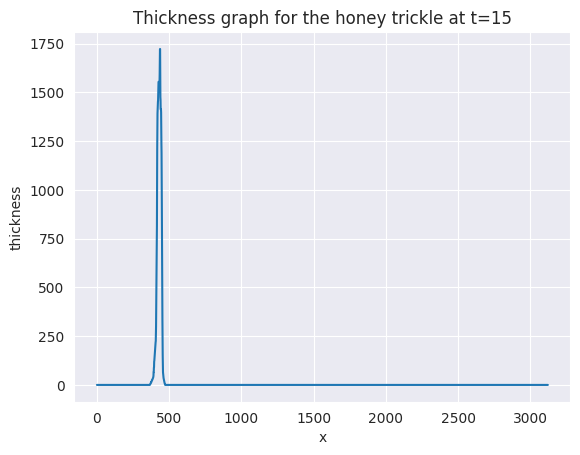

In [112]:
time = 15
frame = time * framerate

layer_thickness = thickness_df[thickness_df['frame'] == 190]
sns.lineplot(layer_thickness, x='x', y='thickness')
plt.title(f'Thickness graph for the honey trickle at t={time}')

## Tip position and velocity

[]

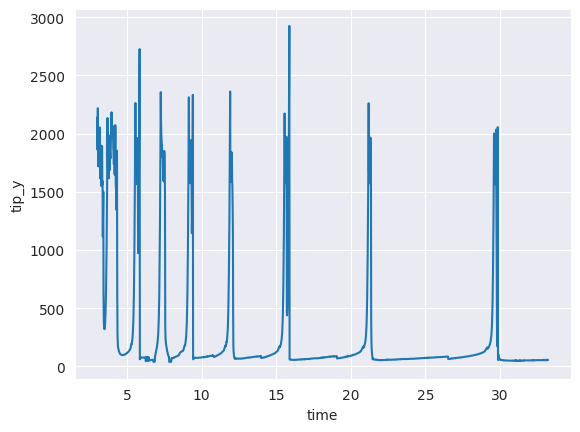

In [126]:
sns.lineplot(study_df, x='time', y='tip_y', errorbar=None)
plt.plot()

<Axes: xlabel='time', ylabel='tip_y'>

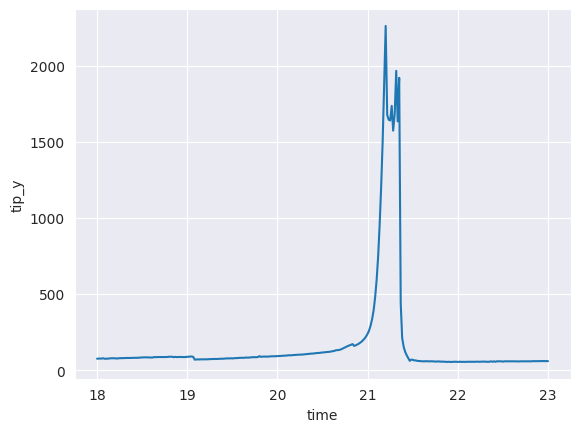

In [127]:
study_df['tip_y_smooth'] = savgol_filter(study_df.tip_y, window_length=9, polyorder=2)
sns.lineplot(study_df[(study_df.time >= 18) & (study_df.time <= 23)], x='time', y='tip_y')

<Axes: xlabel='time', ylabel='area'>

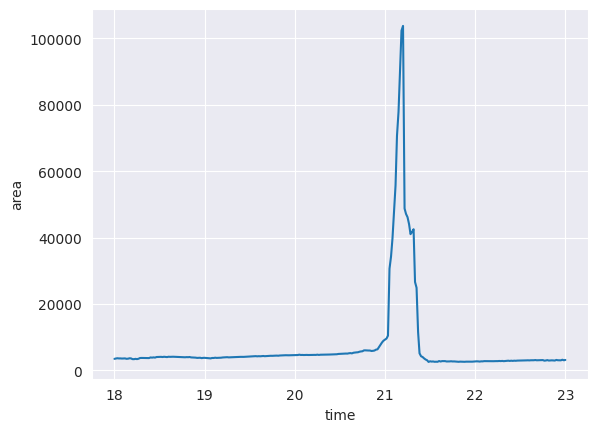

In [102]:
sns.lineplot(study_df[(study_df.time >= 18) & (study_df.time <= 23)], x='time', y='area')

<Axes: xlabel='time', ylabel='v_y'>

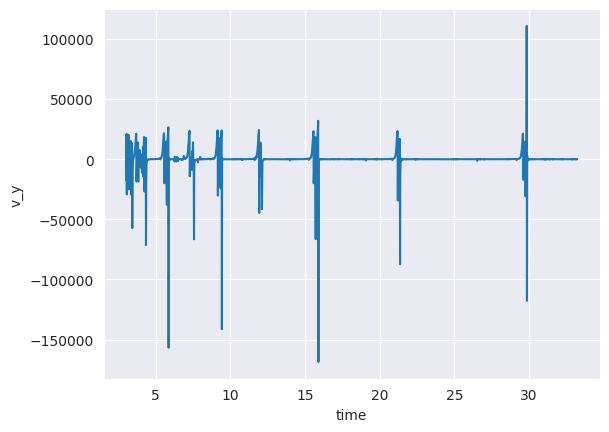

In [134]:
study_df['delta_y'] = study_df['tip_y'].diff()
study_df['delta_t'] = study_df['time'].diff()

study_df['v_y'] = (study_df['delta_y'] / study_df['delta_t']).tail(-1)

sns.lineplot(study_df, x='time', y='v_y')

In [104]:
delta_y = np.diff(smoothed_tip_y)
df['delta_t'] = df['time'].diff()

df['v_y'] = (delta_y / df['delta_t'].tail(-1))

sns.lineplot(df, x='time', y='v_y')

NameError: name 'smoothed_tip_y' is not defined

We observe an oscillation pattern between t=5s and t=8s, let's conduct a Fourier analysis

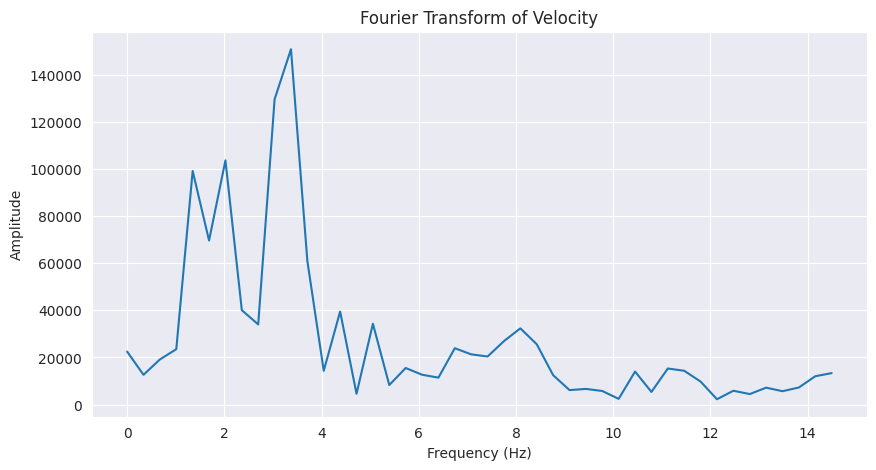

In [32]:
from scipy.fft import fft, fftfreq
import numpy as np

time_window_df = df[(df['time'] >= 5) & (df['time'] <= 8)].copy()

# Step 2: Prepare the velocity and time data
velocity = time_window_df['v_y'].dropna()  # Fill NaNs, or use .dropna() if you prefer
n = len(velocity) - time_window_df['v_y'].isna().sum()   # Number of data points
dt = np.mean(time_window_df['delta_t'].dropna())  # Average time interval between samples

# Step 3: Use scipy's fft to perform Fourier analysis
fft_values = fft(np.array(velocity))            # Compute the FFT of the velocity data
frequencies = fftfreq(n, d=dt)        # Get the frequency bins corresponding to FFT values

# Step 4: Only take the positive half of the frequencies for analysis
fft_magnitude = np.abs(fft_values)[:n // 2]  # Magnitude of FFT values
frequencies = frequencies[:n // 2]           # Positive frequencies

# Step 5: Plot the frequency spectrum
plt.figure(figsize=(10, 5))
plt.plot(frequencies, fft_magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of Velocity')
plt.show()